# Gender classification

## Libraries

In [259]:
import tarfile
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import opensmile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from tqdm import tqdm

## Default Device

In [101]:
if torch.cuda.is_available(): print(torch.cuda.get_device_name())
else: print('cpu')
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce GTX 1660 Ti


## Extract .tar.gz file

In [2]:
input_tar_gz_file  = 'cv-corpus-12.0-delta-2022-12-07-en.tar.gz'
output_dir  = 'extracted_files'

In [3]:
# Create the output folder if it doesn't exist
os.makedirs(output_dir , exist_ok=True)

In [3]:
# Open the .tar.gz file
with tarfile.open(input_tar_gz_file, 'r:gz') as tar:
    tar.extractall(path=output_dir)

## Open Dataset

In [4]:
df = pd.read_csv('./extracted_files/cv-corpus-12.0-delta-2022-12-07/en/other.tsv', sep='\t')
df = df[df['gender'].isin(['male', 'female'])]
filtered_df = df[['path', 'gender']]
filtered_df.loc[:, 'gender'] = filtered_df['gender'].map({'male': 1, 'female': 0})

## Add gaussian noise for data augmentation

In [5]:
def add_gaussian_noise(signal, noise_level=0.005):
    """Add Gaussian noise to the signal"""
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

In [6]:
sound_dir = './extracted_files/cv-corpus-12.0-delta-2022-12-07/en/clips'

In [7]:
for index, row in filtered_df[filtered_df['gender'] == 0].iterrows():
    
    waveform, sr = librosa.load(f'{sound_dir}/{row['path']}')
    noisy = add_gaussian_noise(waveform)

    sf.write(f'{sound_dir}/noisy_{row['path'].split('.')[0]}.wav', noisy, sr)

    new_row = pd.DataFrame({'path': [f'noisy_{row['path'].split('.')[0]}.wav'], 'gender': [0]})

    filtered_df = pd.concat([filtered_df, new_row], ignore_index=True)

In [8]:
filtered_df['gender'].value_counts()

gender
1    16911
0    11136
Name: count, dtype: int64

In [360]:
paths, labels = np.array(filtered_df['path']), np.array(filtered_df['gender'])

## Dataloader

In [357]:
class CustomLoader(Dataset):
    
    def __init__(self, paths, labels, data_dir, target_sr):
        self.paths = paths
        self.labels = labels
        self.dir = data_dir
        self.target_sr = target_sr
        self.smile = opensmile.Smile(feature_set=opensmile.FeatureSet.emobase,
                                     feature_level=opensmile.FeatureLevel.Functionals,
                                     sampling_rate=target_sr)

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index) :

        waveform, sr = librosa.load(f'{self.dir}/{self.paths[index]}')
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=self.target_sr)

        wave = self.smile(waveform, self.target_sr).reshape([len(self.smile.feature_names),])
        label = self.labels[index]

        return wave, label

In [361]:
X_train, X_test, y_train, y_test = train_test_split(paths, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    stratify=labels)

In [362]:
batch_size = 64
target_sr = 16000
train_set = CustomLoader(paths=X_train, labels=y_train, data_dir=sound_dir, target_sr=target_sr)
valid_set = CustomLoader(paths=X_test, labels=y_test, data_dir=sound_dir, target_sr=target_sr)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

## Model

In [354]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=988, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=32)
        self.fc6 = nn.Linear(in_features=32, out_features=2)
        self.softmax = nn.Softmax(dim=-1) # For binary classification
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x

In [355]:
mlp = MLP().to(default_device)

In [356]:
summary(mlp, [batch_size, 988])

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 2]                   --
├─Linear: 1-1                            [32, 512]                 506,368
├─ReLU: 1-2                              [32, 512]                 --
├─Linear: 1-3                            [32, 256]                 131,328
├─ReLU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─ReLU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─ReLU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 32]                  2,080
├─ReLU: 1-10                             [32, 32]                  --
├─Linear: 1-11                           [32, 2]                   66
├─Softmax: 1-12                          [32, 2]                 

## training

In [367]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.001
weight_decay = 0.001

# loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

history = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
min_loss = 1e9

In [369]:
for epoch in range(num_epochs):

    # training
    mlp.train()
    steps = len(train_loader)
    total_loss, acc, count = 0, 0, 0
    for features, labels in tqdm(train_loader, total=steps, desc=f'Training Epoch {epoch+1}', leave=False):
        features, labels = features.to(default_device), labels.to(default_device)
        optimizer.zero_grad()
        outputs = mlp(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        predicted_value = torch.argmax(outputs, 1)
        acc+=(predicted_value==labels).sum()
        count+=len(labels)
    tl,ta = total_loss.item()/count, acc.item()/count
    history['train_loss'].append(tl)
    history['train_acc'].append(ta)

    # validation
    mlp.eval()
    steps = len(valid_loader)
    total_loss, acc, count = 0, 0, 0
    for features, labels in tqdm(valid_loader, total=steps, desc=f'Validating Epoch {epoch+1}', leave=False):
        with torch.no_grad():
            features, labels = features.to(default_device), labels.to(default_device)
            outputs = mlp(features)
            loss = criterion(outputs, labels)
            total_loss+=loss
            predicted_value = torch.argmax(outputs, 1)
            acc+=(predicted_value==labels).sum()
            count+=len(labels)
    vl,va = total_loss.item()/count, acc.item()/count
    history['val_loss'].append(vl)
    history['val_acc'].append(va)

    # save net parameters
    if vl <= min_loss:
        torch.save(mlp.state_dict(), 'best_net.pth')
        min_loss = vl
    torch.save(mlp.state_dict(), 'last_epoch_net.pth')

    print(f'Epoch {epoch+1:3} / {num_epochs} :  Train Loss: {tl:.8f}, Valid Loss: {vl:.8f}, Train acc: {ta:.8f}, Valid acc: {va:.8f}')

Training Epoch 1:  31%|███       | 109/351 [07:00<16:20,  4.05s/it]

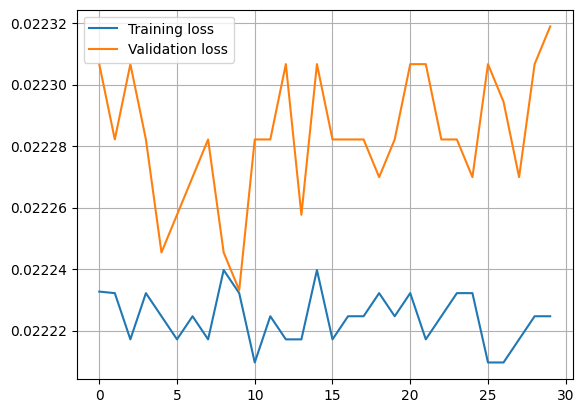

In [ ]:
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.show()

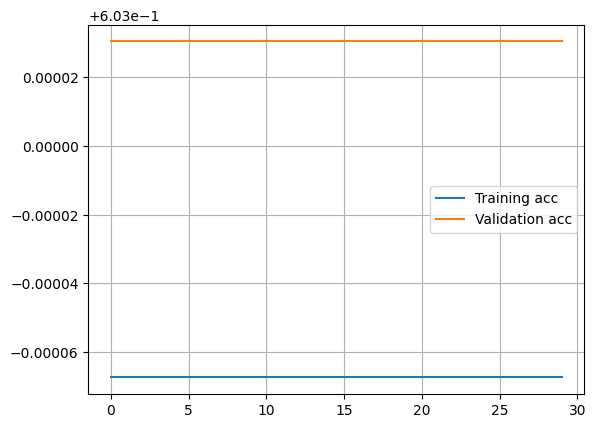

In [ ]:
plt.plot(history['train_acc'], label='Training acc')
plt.plot(history['val_acc'], label='Validation acc')
plt.legend()
plt.grid()
plt.show()

In [313]:
a = iter(valid_loader).__next__()

In [316]:
a[1]

tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0])

In [322]:
torch.argmax(mlp(a[0].to(default_device)),1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

## rest